# dAiv 인공신경망 특강: 정보의 인코딩과 디코딩

#### 들어가기 전에,
##### 이미지란?
- 컴퓨터에서 이미지는 픽셀의 2차원 배열로 표현됩니다.
- 각 픽셀은 색상 정보를 담고 있으며, 일반적으로 RGB(Red, Green, Blue) 값으로 구성됩니다.
- 컬러 이미지는 각 픽셀마다
    - 빨간색(R) 채널 값
    - 초록색(G) 채널 값
    - 파란색(B) 채널 값
    으로 표현됩니다.
- 이미지의 크기는 픽셀 수(해상도)로 표현되며, 예를 들어 1024×768은 가로 1024픽셀, 세로 768픽셀을 의미합니다.

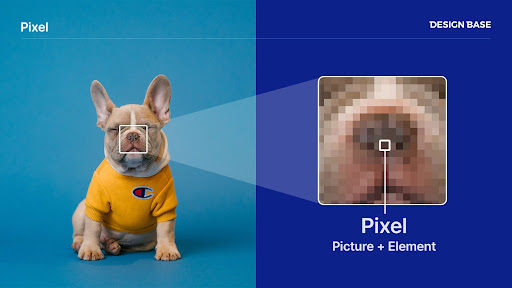

##### 이미지 처리와 압축의 필요성
- 고해상도 이미지는 많은 저장 공간이 필요며, 네트워크를 통한 전송 시 대역폭 문제가 발생할 수 있습니다.
- 따라서 이미지의 크기를 줄이거나 중요한 정보만 추출하는 압축 기술이 중요합니다.

## Imports

In [ ]:
from platform import system

if system() == "Windows":
    %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128
else:
    %pip install torch torchvision torchaudio

Looking in indexes: https://download.pytorch.org/whl/cu128
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
%pip install matplotlib tqdm numpy pandas scipy
%pip install --upgrade git+https://github.com/dAiv-CNU/torchdaiv.git

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import transforms

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'matplotlib'

## Data Load


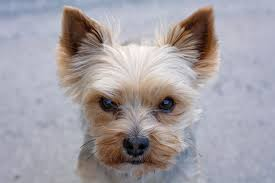

In [ ]:
from IPython.display import HTML, display
from base64 import b64decode
from io import BytesIO

image_data = """
data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxISEhUTEhIVFRUVFRUVFhUVFRUVFRUVFRUWFhUVFRUYHSggGBolGxUVITEhJSkrLi4uFx8zODMtNygtLisBCgoKDg0OGhAQGi0dHR0tKy0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLSstLSstLf/AABEIALcBEwMBIgACEQEDEQH/xAAbAAABBQEBAAAAAAAAAAAAAAADAAECBAUGB//EADsQAAEDAQYDBgUDAgUFAAAAAAEAAhEDBAUSITFBUWFxIoGRobHwBhMywdFCUuFy8RQjYpKiFTNDguL/xAAYAQADAQEAAAAAAAAAAAAAAAAAAQMCBP/EACERAQADAAIDAQADAQAAAAAAAAABAhEDIQQSMUEiMmFR/9oADAMBAAIRAxEAPwDX+Qi06IhANYqXzzC7UEzSCc0QotkpxTckBKLAFKo8aILWFT+QSkZhCiBJyRhQT1KRDS7gCVm1sjRFdlMWR50g9CPRMyW6ghcFab6rMe6Hb5K3Yfi+oCMZxCRiB4brjr5c/sOufFj8l2fzExeU1htFOtmw67cDuFebRAXXW8WjYc00ms5KiWkpi0rS+WndR/hPS9Wf8pEZQkK6KSmKaXsfqzX2NJllWkGJCmjR6qTaCMaOSsimpYUtGKLaSl8pW8IQyjRiv8pTDURqm5wAkmANyjTiATTUXQNSubv34sa2WU/Fcy74nqE6rmv5OdVjXTTx97t09HpvBMBTc1cr8L2173FzjquqxqvFyTeuyly0ilsJrJS+WnFRMXqqZnNTQmehklAEapShBRcTKAsJIYcUyAp/4VSbZVewJALWjFdlIBTgKRSASBvlp200ViJhSAYooF6dmk49yuAqjfp/yXKfJ/WWqf2h5PfGp71kkOObfBaF9O9SFQprgzp3frUuS/X0agB0cMxOsDUcD+V6XdPxDTe1ofPa0fv/AOw0XjFsYdW7Gei1/hu31WjH9TGmXAZuYNcQbqRrIG3ctRNq9xJWrFupe4NblkQQdCNCiYcunof5XM3Lekx2gWuaHtiC0jcjkujs1cEkLory79c1uPPggaCeuvVQcUeyjT370VV+sKsSnMEHKQUC1IBaIvmJSfBOGIop9klKZGIObqghu6tVPtHgse8bfhGX1F2EfnuU7cnrDdabOJXheDKQlx7lwXxH8Wl8taYA4aLY+I6Aqw0vwtaJe7iBt1PkvNrRZnvcSGkMBME5dnY/dct+S15yZyHVSlaxsfTutZdpnuT1TMcQQiUaIbpoqtpcJHVKKtzL0L4Rfie0DRd58tedfBNb/MHh0XpS6PGn+MufyI/kr4EsKNhQ3hdGoIlqgWIzVEoAYCfCiAJQmQWBJEToADa6arU4JmsU4TJCgSjFqiwIgRp4gGwiYkk0JaMJwKyPiG04aZaRqMj9ltgLn/i6xEtBEmOWihz2yinDXbPLr1Jgwd+MqmKuQGqu3szMg6z0PmsezEl+HATwAmVy0+Oq/wBbV20XBweWYm79FvWiw0nAOYBSqfpqMyE7Yh7BQrustVjRhLsxmyo2fMKwCZORaTqDm09d/XqFv1Y9gvhq3OFT5TgGua/Fh0ALv+6G/wClwOMDiCvQrPULXsO04fNcNY7spvr03uL2FpGbQHNIPPce+vo1a7HOEsIcG6YdRHJaiOmZntqDJvNVSxXmskA7x3LOtFkruMBsAHWQq1tEJTBBwT0zJyVujcpjN2fvRPZrseHHKRCfsWKxY5HoDskFWatndEYdtkHtMAJacvGN1m1ujiO1S3HDi/pcfD+64y1WiagM5MaXeJhvkCe5dleljc8fUGggiTqQY0G5yXD3xdFomKbXQ4y58RhaMhAOp/uue/tK9PWGLb7S6s/ANAZfwHBp49NzyGYrS6i0QQarhtMMaeLvZVn5LWNwDsjfiTvmfVPZ7I39jnxoA0hgPMnfmsRXvZUm3WQ5e1A65Achl3LFe6X5Ad4XXX/aHNywMaOMk+Yk+a5Rhxv27pPmqT8Zjt2fwlWwvnp7heoWd+JoOS8quGiSBG5XqV2ZUwIAA5a80/Ft+M+TH6sgJOCeUiuxyhBMSpwoEJgpUZSTFMilJRlJMEAnAUw1MQshEBT0SBUkAgnwJKQKAdjYWdegDtXEea0hmse96mUQFy+T1Do4Przv4nsJBJyPMZgrn7ou9wfjIeGDgAB/yPoF3lppNdkWmfH8qxZrA05imSf3EER3u/ClxQrySxmWuIAa6Nsy7yBAWjZpd/43Z8RHlBV42XB9TmMHBsEnwEItGu1v6e9xElW+I7ol30XtM4XEcCBB8l1lhtJPabkd2n7HVYdgvUA50yegdHouisdrpv2wngfsloxpMqBwDhkfXkfyjvaC3EN9RwWYQWGdWnyVyy1tRx8EyWqL+yPBEa+JVIPgFE+Z76BMk6tTOFXc3PiU1N0klNUtAGnvr+EA1ZpGep95SsC8aFZ2zG9S6fELYLnHPTnHpsEGpT/q7yR6LTLkbTc1QnFiA4luET1cVTr3bH1/O6jF6hy6i13eDmC5p5HI9Rv3hc/aLH8qYb30y5p/2zHgszRuLuTvy5qTmksxYti97p83GVytlsoxRixGf2QO4zmu6vbBVGEVH4htJIP9RaAe6VSuq5GMMuqAno37SocvzHRxf9lofD1jgAbb/wASu+pgBjcolYV22ZojtCPDzXQV2DC2PGfsn40ZLPkTsBF0KLnqJqJELucaReouUHBRqPgJhOUxKGxyclMESknTIAxcnBQMWakFkDAJFOxM5AOAiNQqZRQgHJWZbg0ytEhZdspnbNQ542qvFOSw69IySHAdSfsEF9YjJ1buaCXd2w9Vo2qytAlzvT35rLrWxjPpE8miJ6lQpPqtaNKnZyT2QGg5yZLzzk5+ELasFhaIyk8XLOu9xd2iInMN+54963rE0HeOPE9+ypqbSstnP7h0hx9FdbZJ2J6Ej1CHZA3Rpk/1TH4Vs03/ALvOfIplpmEgQc9ocI/5BMezmPp4bhENc/qEqLiNvDZMk3unvCes/Xnl6Ktjju9EOtXzA6nxKUycQsOqbAwOKNRpDWO92vgqQrBuuvp0R6dcn+UotAmB6r+B/KqVGv8A9J6yrIqzw7lEgHPzVIljFAl20c+H5Cq3jYhVaYOF+3A9Vo16QOfnoR3rOr1TT5jdaJx1a5Ycfma89O8A59UejdYOtWR+0Q0flbF52kkDCddDhxRyIVezUiT/APJAXNfj7dNeTpbu+yMaR7HotW0RkBpChZKZAzAHRQrug5KvDTEuW+hvU2tQ8cqXzV0oncxQLFKUzygBOakpEocoB8SSikmQqkCh4k6yYwKeVXpI4QD4gFEPSLU+iATZVS2TOnT+yuY0zo1WbRsYcTkuetVlc+TB6wqBsLWmfqI3OgXQ2hxcYGQ95lVLRQy4MGp0krlmsQvFplTszJyBzPkt67aDQe0fGM+qxrKJBOg+wQLVeAaZBjyWZtEHFZl6FTqACAR0TGr07jPlquAsfxQBkSD0gHuB1Wn/ANXLxLSHjcQA8dRIlUraLfGZpMOitFcamRzH3VCpbYOv8rk7Xeb8y1xHEZ5HgWmCPBDo3g57ZPXw/hYtZutenYi2gqFW0wZnYLnG2wgDmR6FNaLad+A+6xMzjURDe/xWfMqZt4GU5rmRbSJPLzQGWv8AUddB+UoOYdcLzEa5eqtUL0xZae+P8Lh324DfRW7BeYJ+oeIWq37ZmnTvWObGufHWOkqnbaRw8eg+yy7Nbx+0nnM+crUo2kHiPfRdEWRmuManTl0Ekc4nyWmyz4Y7WLuRnUmHMQChFsLVa6zMlXtMBUadQuKsVWYlXEtcqxDCyKYCBW1R5TFqYCNSBKiyqHIlRuUKuylCAlVahU3FEaTKm5oTI2FJLEnQaIRGoWSdj1kJFSpuQ3vU2BANXqkaKdN0jNIQU7kBJpU3BBLlIOQEgwDhKybeHO10HgtWFCq8QclO1darbHN2uvgYBpuVydvtTnEwDC6y8oIJGsxp5Ln6lDPb30XHyV7dXHbpxV9Wh4cAC4ZgknQ5xotK7r3qNaXF/wBM6/WY1Efq81a+IbpNRuJozG2WYXLMovkTkRvBxZcctVbj9c7jU+T23p2Fn+IG1BiDsspnIicpW7YHTpvM++q4KwOAfJYTscOrgdiIy49y9AueC0FrMJ/acv7LMcff1qb9fBmkyGniE16E4Z3JA71fbQD4dEFpz6R/CsusIe0DgZ314/ZamsYxFp1zDbVGKdBuq1rtmAEzstq8brDQR45eUnILkL4s5qNOFzdx9bco2gKUccq+8Kdotj7TLKb4wxiOeczGc5BUrpvCrSqBrnS0znnHZ36KqLvfM4ATvhIInvjyWxc91l9UYx9PgB+SuiaVimZn+oxe03+u4ua9Dv4ggg9V01jqzoSDwC52z2UbRHot666Iy35qNYlS+NljzHPmEolEp2ZxiIjmUKs0tdHouurmkxyUCpOCbCtEcFRe5PIUSQgIuUcCkExTAJMFSKc00oQA4SRhTSTCuGqQAQsZRWhZBjTlEGShiUyUBJiaog1Z2QfmnRAWJRmAqqWHVWGVckgM54CDaIiU9UAoVQZIDDtI146wsWvTjMrctFPtkjQLLtrJB3nh0XNy1/V+KfxjvrAc+vhlwTtDHagTxRm2OcoPUwB5q1ZrCAe03uXPG66JzHPOsADsLcUvknCJdEzHTRdTc1iLIkOHNzY7pG3VadjpN3DR74LTYBGRHSFaspWVKVSHTywuHofBXjVDANOZ3jgOqz7ZUA5H1G4RbteKhDpngOuZIVc6T0O30fnAktdEZA5Nj2NVx9tuo06oP1NMxkBnu0xuvTnWEuzjxPqsu8Lqp1AWntf0z67fwifh1+uLbdNJx0HEHJaNGwxk3CD/AEie+CtF10OGUGNp1HejU7qOW/cQQpfy+KbEdhWO7ic6jyR+3IDw3710NnbAyEBCsdmI4nrsp2iqJjFJ4Dbqq1rkI2tstJjjhkZcwqWIz15yq7qrnGJy4IwKtEYlIoKGSncYUSUwk2FEAIZSqaZICZKYlC2SL0wIXpnFVqjTOSmCUwJiTpApICtVfwUWViNU7cincAVkGbUzVjEhYAnY5AHMQmY0KQhDISNN7VAtUwmQBCwKAppwUsaRMi9AGA5xKxY7MgzzWr8SVwAMR/uudsrsToDQJ/dJP+0fcqV41Sk4sNdHXzU6dqcNj4A+soVttLacgAA9w8Ssl9tcePoPErktMOusS3q3xA2kO00E8IaD5BApfEYdqzB4x5fhZAqhwjsk8pPi469ywL3vI03gNAyBJO54LdNmSvkQ7C8LzxCZ5gnePXrr4K7cNtAEyNeyNehI39npxVhvLGwDENO1kBPKI996MLyc1obikbAwe6Cu2K645s9CvK93tHafPIxPgThb3qd3W551IA1j6iZ359VwtivV1Wabu02JAEDCd4Wzddb5fZJ7O3Fh/Hvrzcu1ti/Hlqu5+e4jSfD0Eoba+xgHaZH91Uo1XBoM4uhifFDdap7Lma5dofeEvbOxmtWTGp98tFluGHPnxz6rQsb5ZhEgjSZzHUDPyWfVpuOROEnoQffIro452ELxktKyEHNHqBUbrBgg7K49UYhIFQehl2ylsg0gQouKQGSZAQDkmhO6EpQDFMckiUwMpgyZMWpIBioSnxJMSMXBko/LUnPU3DJIIkqZGSA0opKAIEjmEMuyUmjJIJU8kn1QFBpVW8KmGm50Zxl3oDl77tAdUJJxEZA7dGjYezKHdjA90wYGfAflUKrJkkp7FVIcNcP7Tv1H2UdbwW3uaDkBnpsOqoOwDMgchHnKvXhDjin3w6rHqntZ6bDM6aLltHbspPS3UrtGcbTGnesG/LE57fmjYQcsss0W02vszrPv33JWO1BwwOzBAnvErfFsT2xyxsdMG7Q5riSQWwfypXjRe5wIIAMRJ8yr1pupoH+S4yZyOgGwnfZEpXS0DHUeSW/p20JHmD4LqjHLk/F+4bEWAucTMe497LorE46wHDnkenJYLbZmANJ+/vwK3bMAc2nXUephc/Jb2l08dfWGzYa7WfSXM5aDw0K0mXw4DtgEfuaI8QPsubdTqDMObHAiZ8Cr9hpnDJAnlKxWJ3IO0xmy6Ojag2HYsjlt4hUrVeXzCYAyOeWqyScQiIg+qtWOzESeJ33XfSmR24r32emxdtTWffIq7KzLFRImTEjKNeqttcYzieSAK8SlKQUPmJmOwqFQJ8QUKlTZBISkDKGwKQMJg7zCjKUymlAIpKGNJMjtanTYlKm+NVlozNUQv2QjUB0KgUgc6qTVEOUqZG6QFKYPhRcUxhAFOap3uYpHmrLXKpbWk5HRYt8Ov1yzqUjMKBoLSrsGirvYowsy8IMhwnPJULTdzyZaZzyhbb6CqNeRI0zTmkSK3mGELpJIz7lbs/w8P3HPeY8IW7QY0jtCY8VKpVY3jrCdaYLcmudtPwySRgqGBnBnu095JUfhpwnFUO+mevXoF1kQ0RvPkq+M4gBnOv3WrTnTNY3tzD7mMQ0mBz0235K1SoPbqehEg+S37PZZnb7qxZ6OGZzzy8B95U44plSeWIZljc+QOO516SFvNtDmjtZ+RWfjwuyA8ERzy7XircfFMfUb8sT8WGdrOVo0Gk7rOsbS1btlYCJCujhrNS7Uzn5IrmqZwg9o9wTOdHRY/WvwsSemQhB6ROa0BnOQ6j5SUSEBKm5O7goVGwk1yAZzIUS5SdUkqDolOCFbhSVeEkyO4KFVpIhOkpy2jQs4YEQlMkkBWDJMkkgI4s0WQkksmWJQc6dkkkEybXREqp/hpSSUsUiUalKFn2qgkkmRqJVj5I39lJJOokdpyyTWej25J4wNgnSVIj9YmRDUjIKDamqSSW9jEQ39SPZqU5p0lSPjEtGlT2hWaDHN6JJJScSsUGAuzRarIEhOklBqdN53RXFJJbIxUXkwkkgIVHGFAApJJkcGUVjBCSSAGQkkkgP/2Q==
"""

img = Image.open(BytesIO(b64decode(image_data.split(',')[1])))

html_img = f'<img src="{image_data}" width="500"/>'
display(HTML(html_img))

이미지 보간법(Interpolation)

주변 픽셀 값을 기반으로 이미지의 새 픽셀 값을 추정하는 방법론

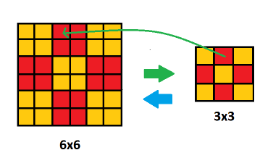

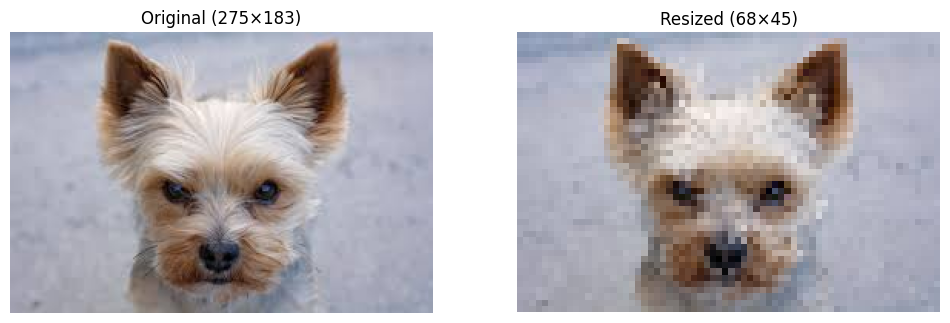

In [14]:
# 가장 가까운 픽셀 그대로 복사 = Nearst neighbor interpolation

# 2) 4배 축소 (Nearest Neighbor)
new_size = (img.width // 4, img.height // 4)
resized_img = img.resize(new_size, resample=Image.NEAREST)

# 4) NumPy 배열로 변환

# 5) 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(img)
axes[0].set_title(f"Original ({img.width}×{img.height})")
axes[0].axis("off")

axes[1].imshow(resized_img)
axes[1].set_title(f"Resized ({resized_img.width}×{resized_img.height})")
axes[1].axis("off")

plt.show()

풀링 방식

컨볼루션 신경망(CNN)**에서 사용되는 중요한 연산으로, 이미지를 축소하여 중요한 특징만 추출하거나, 계산을 효율적으로 처리하는 방식



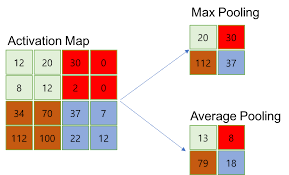

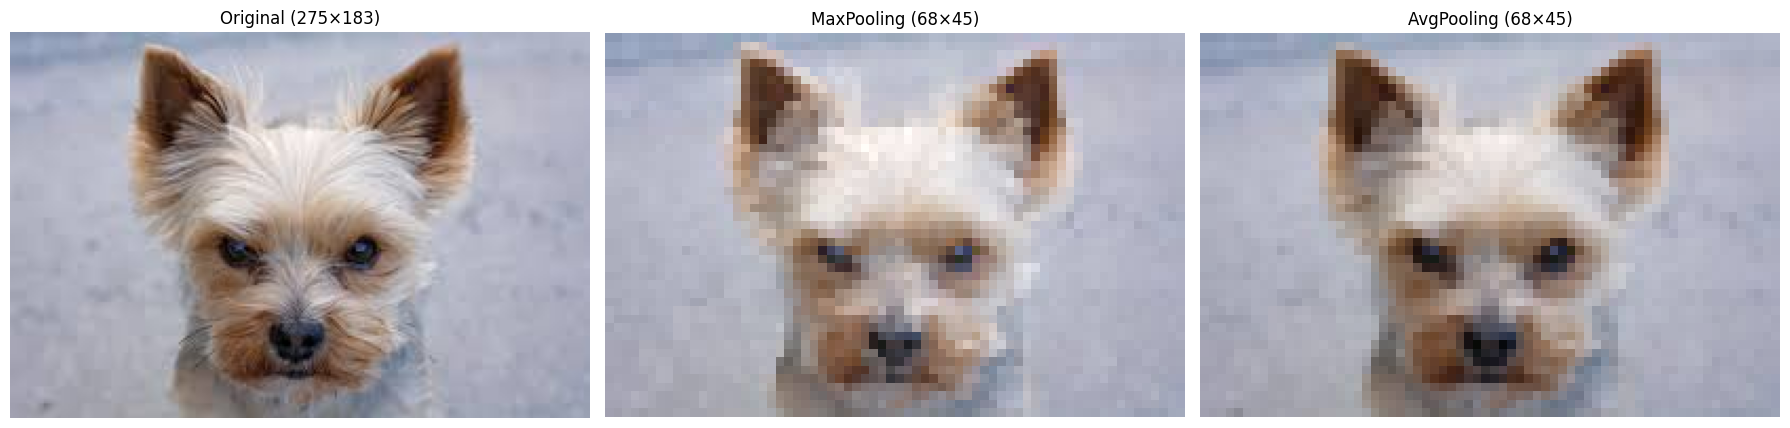

In [15]:
# 2) ToTensor & 배치 차원 추가
transform_to_tensor = transforms.ToTensor()
img_tensor = transform_to_tensor(img).unsqueeze(0)  # [1, C, H, W]

# 3) Max‑Pooling (kernel=8, stride=8) → 너비·높이를 1/8로 축소
max_pooled = F.max_pool2d(img_tensor, kernel_size=4, stride=4)
avg_pooled = F.avg_pool2d(img_tensor, kernel_size=4, stride=4)

# 4) 배치 차원 제거 & PIL 이미지로 변환
max_img = transforms.ToPILImage()(max_pooled.squeeze(0).clamp(0,1))
avg_img = transforms.ToPILImage()(avg_pooled.squeeze(0).clamp(0,1))

# 5) 크기 정보
original_size = f"({img.width}×{img.height})"
max_size      = f"({max_img.width}×{max_img.height})"
avg_size      = f"({avg_img.width}×{avg_img.height})"

# 6) 시각화: 1행 3열
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# 원본
axs[0].imshow(np.array(img))
axs[0].set_title(f"Original {original_size}")
axs[0].axis("off")

# MaxPooling
axs[1].imshow(np.array(max_img), interpolation="nearest")
axs[1].set_title(f"MaxPooling {max_size}")
axs[1].axis("off")

# AvgPooling
axs[2].imshow(np.array(avg_img), interpolation="nearest")
axs[2].set_title(f"AvgPooling {avg_size}")
axs[2].axis("off")

plt.tight_layout()
plt.show()

컨볼루션 방식

이미지나 신호 처리에서 특정한 필터(커널)를 사용하여 입력 데이터를 변환하는 방식


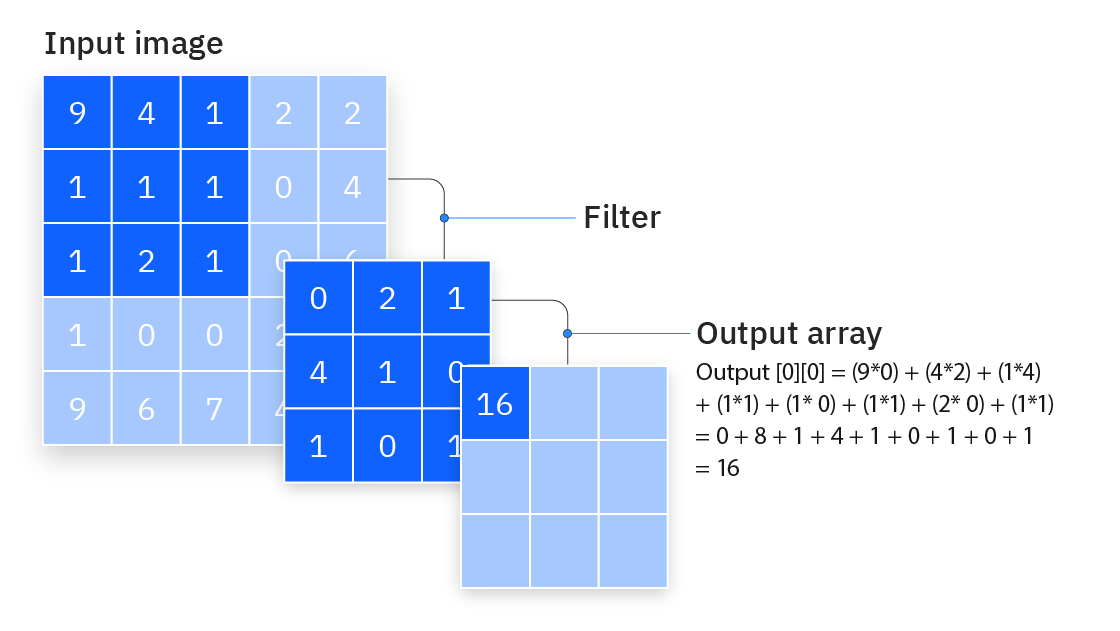


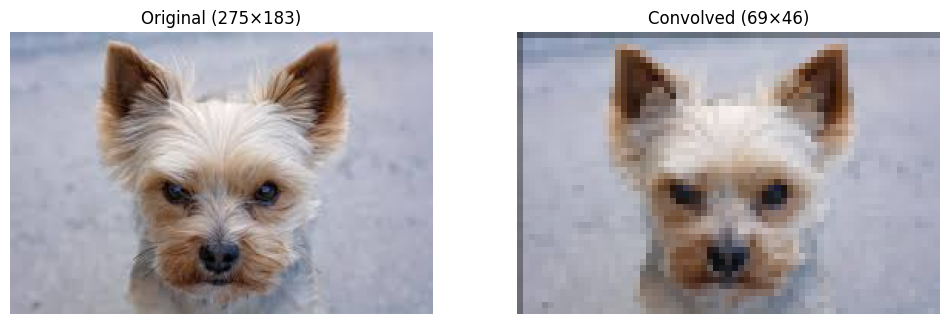

In [16]:
transform = transforms.ToTensor()
img_tensor = transform(img).unsqueeze(0)  # [1, C, H, W]

# 2. 평균 필터 (3x3) 생성: 채널별 독립적으로 사용 (groups=3)
avg_kernel = torch.ones((3, 1, 3, 3)) / 9.0  # [out_ch, in_ch/groups, kH, kW]

# 3. Conv2d 정의: groups=3로 RGB 각 채널 독립 처리
conv = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=4, padding=1,
                 groups=3, bias=False)
conv.weight.data = avg_kernel
conv.weight.requires_grad = False

# 4. Conv2d 적용
with torch.no_grad():
    out_tensor = conv(img_tensor)

# 5. 텐서를 이미지로 변환
out_tensor_clamped = out_tensor.squeeze(0).clamp(0, 1)
img_conv = transforms.ToPILImage()(out_tensor_clamped)

# 7. 시각화
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# 원본
axs[0].imshow(img)
axs[0].set_title(f"Original ({img.width}×{img.height})")
axs[0].axis("off")

# 컨볼루션 결과
axs[1].imshow(img_conv)
axs[1].set_title(f"Convolved ({img_conv.width}×{img_conv.height})")
axs[1].axis("off")

plt.show()

## 실습 2
- 데이터를 기반으로 이미지 정보량 축소, 복원 (오토 인코더를 통한 자동 모델링)

**오토인코더**

**오토 인코더(Autoencoder)**는 **비지도 학습(Unsupervised Learning)**의 대표적인 모델로, 주어진 데이터를 압축하고 재구성하는 방식으로 학습하는 인공 신경망입니다. 주로 특징 학습(Feature Learning), 차원 축소(Dimensionality Reduction), 노이즈 제거(Noise Reduction) 및 이미지 생성 등 여러 분야에서 사용됩니다.

오토 인코더는 입력 데이터를 낮은 차원으로 압축하고, 다시 원래의 데이터로 복원하는 과정에서 중요한 특징을 학습합니다. 이 과정은 네트워크가 입력의 중요한 특성을 추출하도록 유도합니다.

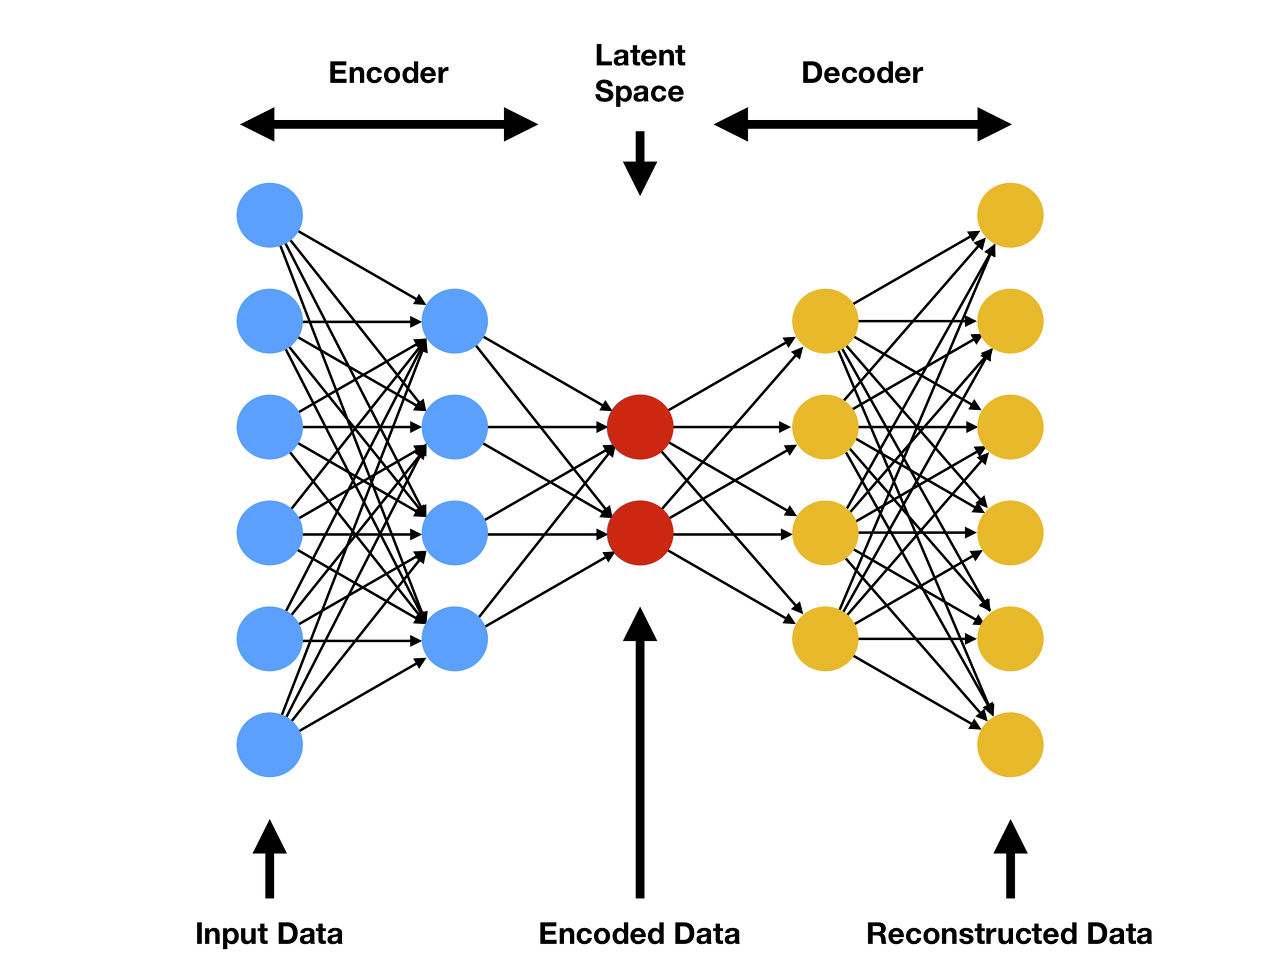

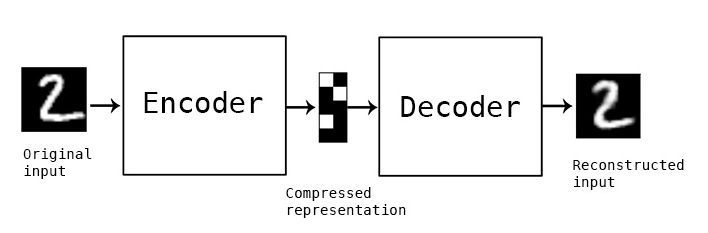

In [17]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # 자동 크기 조정
    transforms.ToTensor(),  # 텐서로 변환
])

img = transform(img)  # 리사이즈 및 텐서로 변환
img = img.unsqueeze(0)
img_batch = img.repeat(4, 1, 1, 1)

**DNN**

**DNN(Deep Neural Network, 심층 신경망)**은 여러 개의 **은닉층(hidden layers)**을 가진 인공 신경망입니다. 기본적으로, DNN은 **다층 퍼셉트론(Multi-Layer Perceptron, MLP)**의 확장 형태로, 여러 층을 거쳐 입력 데이터를 처리합니다.

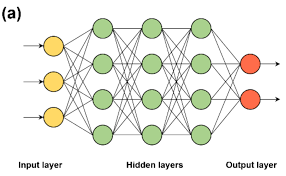



**CNN**

**CNN(Convolutional Neural Network, 합성곱 신경망)**은 컴퓨터 비전 분야에서 널리 사용되는 딥 러닝 모델입니다. 특히 이미지 인식, 영상 분석, 패턴 인식과 같은 작업에 효과적입니다. CNN은 전통적인 **다층 퍼셉트론(MLP)**과 달리, **합성곱 연산(convolution)**을 사용하여 이미지나 시퀀스 데이터의 특성을 추출합니다.

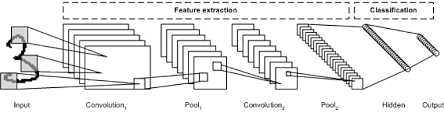

**DNN-DNN**

In [18]:
class Autoencoder_DNN_DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_dim = 3 * 128 * 128  # 49152

        # Encoder: 급격한 축소
        self.encoder = nn.Sequential(
            nn.Flatten(),                   # (B, 3, 128, 128) → (B, 49152)
            nn.Linear(self.input_dim, 16*16)               # 잠재 벡터: 4차원
        )

        # Decoder: 다시 복원
        self.decoder = nn.Sequential(
            nn.Linear(16*16, self.input_dim),
            nn.Unflatten(1, (3, 128, 128))
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder_DNN_DNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

img_batch = img.to(device)

# 2) 학습 루프: 100 에폭
epochs = 100  # 100 에폭 설정
model.train()  # 학습 모드
for epoch in range(epochs):
    optimizer.zero_grad()
    output_batch, latent_batch = model(img_batch)  # output: [4, 3, 128, 128], latent: [4, 256]
    loss = criterion(output_batch, img_batch)  # 원본과 재구성된 이미지 비교
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:  # 10 에폭마다 출력
        print(f"Epoch {epoch + 1}/{epochs}  Loss: {loss.item():.6f}")

# 3) 평가 모드로 전환 & 결과 얻기
model.eval()
with torch.no_grad():
    recon_batch, latent_batch = model(img_batch)  # 재구성된 이미지 및 잠재벡터


Epoch 10/100  Loss: 36.331543
Epoch 20/100  Loss: 0.486409
Epoch 30/100  Loss: 1.694818
Epoch 40/100  Loss: 1.670404
Epoch 50/100  Loss: 0.401423
Epoch 60/100  Loss: 0.498570
Epoch 70/100  Loss: 0.365343
Epoch 80/100  Loss: 0.328205
Epoch 90/100  Loss: 0.220340
Epoch 100/100  Loss: 0.111649


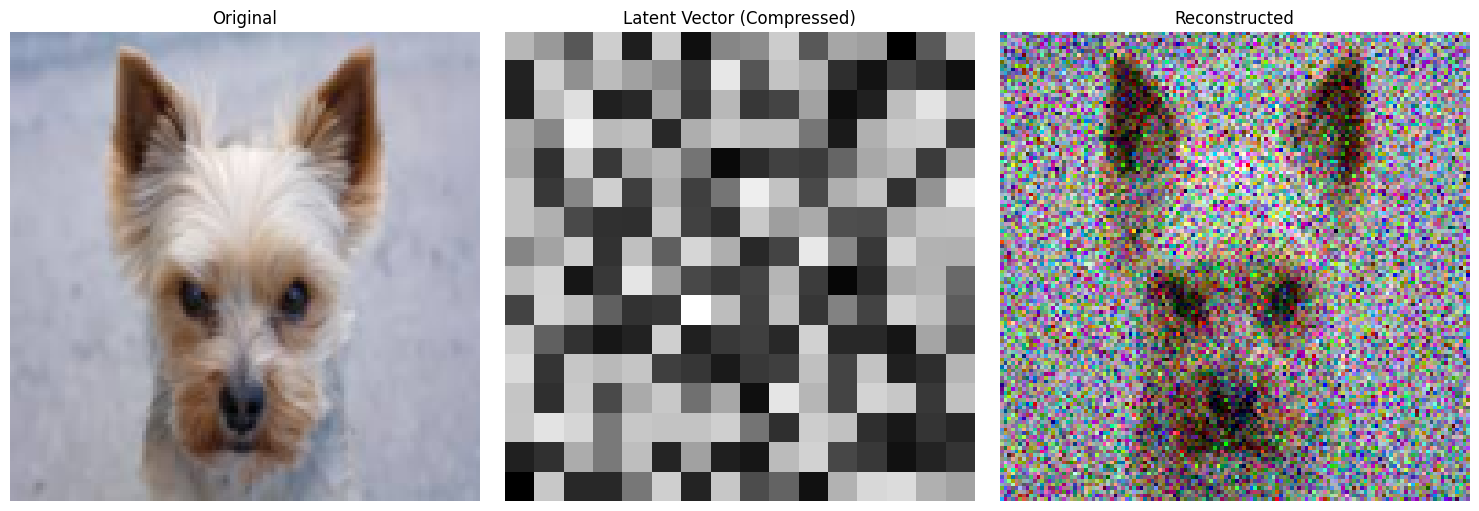

In [20]:
plt.figure(figsize=(15, 5))

# 원본 이미지 (128x128)
plt.subplot(1, 3, 1)
plt.title("Original")
# 원본 이미지를 그대로 출력
plt.imshow(img.squeeze(0).permute(1, 2, 0).cpu())  # 배치 차원 제거 후 시각화
plt.axis("off")

# 잠재벡터 (압축된 잠재벡터 시각화)
plt.subplot(1, 3, 2)
plt.title("Latent Vector (Compressed)")
latent_vector = latent_batch[0].cpu().view(16, 16)  # 첫 번째 배치의 잠재벡터를 16x16으로 변환
plt.imshow(latent_vector, cmap='gray')  # 잠재벡터를 그레이스케일로 출력
plt.axis("off")

# 재구성된 이미지
plt.subplot(1, 3, 3)
plt.title("Reconstructed")
plt.imshow(recon_batch[0].cpu().squeeze(0).permute(1, 2, 0).clamp(0, 1))  # 첫 번째 배치 이미지
plt.axis("off")

plt.tight_layout()
plt.show()

**DNN-CNN**

In [21]:
class Autoencoder_DNN_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_dim = 3 * 128 * 128

        # 인코더: DNN
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.input_dim, 16 * 16)   # 잠재벡터 256차원
        )

        # 디코더: CNN
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1, 8, kernel_size=4, stride=2, padding=1),   # (1,16,16) → (8,32,32)
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=4, stride=2, padding=1),  # (8,32,32) → (16,64,64)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1),  # (16,64,64) → (3,128,128)
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)                             # (B, 256)
        x = latent.view(x.size(0), 1, 16, 16)                # (B, 1, 16, 16)
        out = self.decoder(x)                                # (B, 3, 128, 128)
        return out, latent


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model = Autoencoder_DNN_CNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
input_tensor = img_batch.to(device)

# ───────────────────────────────
# 3. 학습 루프
# ───────────────────────────────
epochs = 1000
model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    output_batch, latent_batch = model(input_tensor)
    loss = criterion(output_batch, input_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}  Loss: {loss.item():.6f}")

# ───────────────────────────────
# 4. 평가 및 시각화
# ───────────────────────────────
model.eval()
with torch.no_grad():
    recon_batch, latent_batch = model(input_tensor)


Epoch 10/1000  Loss: 0.037407
Epoch 20/1000  Loss: 0.017878
Epoch 30/1000  Loss: 0.013429
Epoch 40/1000  Loss: 0.012387


Epoch 50/1000  Loss: 0.011609
Epoch 60/1000  Loss: 0.011025
Epoch 70/1000  Loss: 0.010599
Epoch 80/1000  Loss: 0.010328
Epoch 90/1000  Loss: 0.010136
Epoch 100/1000  Loss: 0.010008
Epoch 110/1000  Loss: 0.009826
Epoch 120/1000  Loss: 0.009661
Epoch 130/1000  Loss: 0.009510
Epoch 140/1000  Loss: 0.009394
Epoch 150/1000  Loss: 0.009286
Epoch 160/1000  Loss: 0.009128
Epoch 170/1000  Loss: 0.009016
Epoch 180/1000  Loss: 0.008902
Epoch 190/1000  Loss: 0.008781
Epoch 200/1000  Loss: 0.008847
Epoch 210/1000  Loss: 0.008591
Epoch 220/1000  Loss: 0.008433
Epoch 230/1000  Loss: 0.008276
Epoch 240/1000  Loss: 0.008116
Epoch 250/1000  Loss: 0.007920
Epoch 260/1000  Loss: 0.007851
Epoch 270/1000  Loss: 0.007490
Epoch 280/1000  Loss: 0.007199
Epoch 290/1000  Loss: 0.006864
Epoch 300/1000  Loss: 0.006528
Epoch 310/1000  Loss: 0.006273
Epoch 320/1000  Loss: 0.005893
Epoch 330/1000  Loss: 0.005564
Epoch 340/1000  Loss: 0.005248
Epoch 350/1000  Loss: 0.004906
Epoch 360/1000  Loss: 0.004711
Epoch 370/100

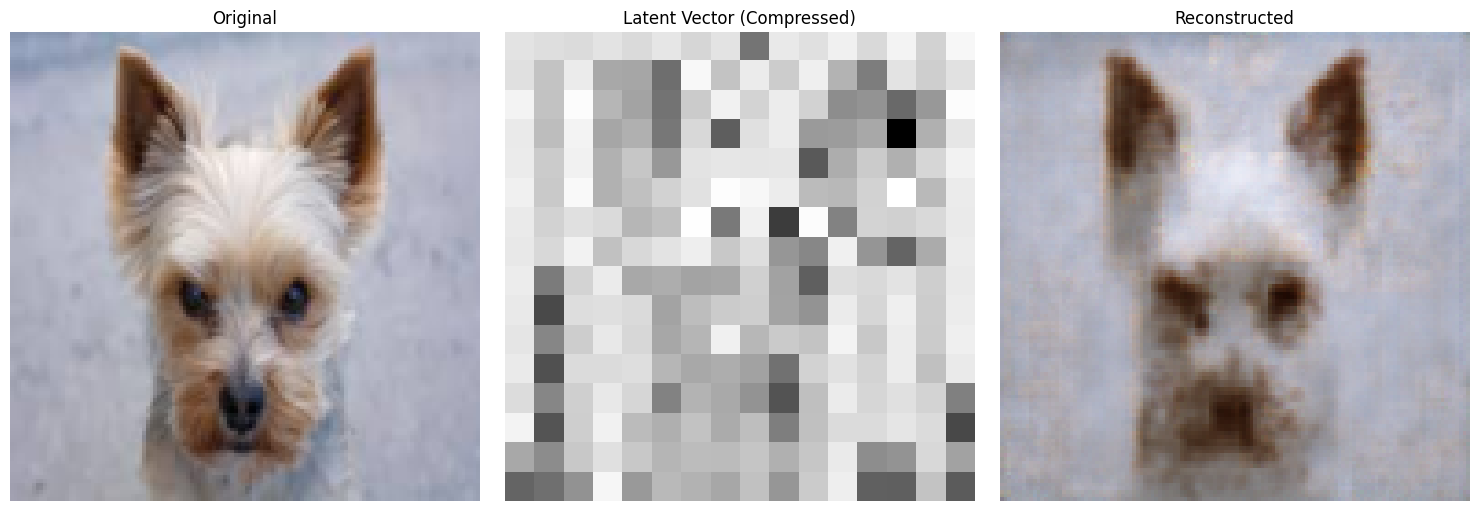

In [27]:

plt.figure(figsize=(15, 5))

# 원본 이미지 (128x128)
plt.subplot(1, 3, 1)
plt.title("Original")
# 원본 이미지를 그대로 출력
plt.imshow(img.squeeze(0).permute(1, 2, 0).cpu())  # 배치 차원 제거 후 시각화
plt.axis("off")

# 잠재벡터 (압축된 잠재벡터 시각화)
plt.subplot(1, 3, 2)
plt.title("Latent Vector (Compressed)")
latent_vector = latent_batch[0].cpu().view(16, 16)  # 첫 번째 배치의 잠재벡터를 16x16으로 변환
plt.imshow(latent_vector, cmap='gray')  # 잠재벡터를 그레이스케일로 출력
plt.axis("off")

# 재구성된 이미지
plt.subplot(1, 3, 3)
plt.title("Reconstructed")
plt.imshow(recon_batch[0].cpu().squeeze(0).permute(1, 2, 0).clamp(0, 1))  # 첫 번째 배치 이미지
plt.axis("off")

plt.tight_layout()
plt.show()

In [92]:
class Autoencoder_CNN_DNN(nn.Module):
    def __init__(self):
        super().__init__()

        # 인코더: CNN (3개의 Conv2d 레이어)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=15, padding=1),  # (3, 128, 128) → (16, 128, 128)
            nn.MaxPool2d(2, 2),  # (16, 128, 128) → (16, 64, 64)
            nn.Sigmoid(),  # 활성화 함수
        )

        # 디코더: DNN (3개의 Linear 레이어)
        self.decoder = nn.Sequential(
            nn.Linear(10092, 1024),  # 1024 → 1024
            nn.ReLU(),
            nn.Linear(1024, 4096),          # 1024 → 4096
            nn.ReLU(),
            nn.Linear(4096, 3 * 128 * 128), # 4096 → 49152 (복원된 이미지 크기)
            nn.Sigmoid(),                   # 0~1 사이의 값으로 복원
            nn.Unflatten(1, (3, 128, 128))   # (B, 49152) → (B, 3, 128, 128)
        )

    def forward(self, x):
        x = self.encoder(x)  # CNN을 통한 이미지 압축
        out = self.decoder(nn.Flatten()(x))  # DNN을 통한 이미지 복원
        return out, x

In [93]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder_CNN_DNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
input_tensor = img_batch.to(device)

# ───────────────────────────────
# 3. 학습 루프
# ───────────────────────────────
epochs = 10
model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    output_batch, latent_batch = model(input_tensor)
    loss = criterion(output_batch, input_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}  Loss: {loss.item():.6f}")

# ───────────────────────────────
# 4. 평가 및 시각화
# ───────────────────────────────
model.eval()
with torch.no_grad():
    recon_batch, latent_batch = model(input_tensor)

Epoch 10/10  Loss: 0.003288


In [94]:
latent_batch.cpu().squeeze(0).permute(1, 2, 0)

tensor([[[0.1927, 0.2126, 0.2616],
         [0.1869, 0.1875, 0.2428],
         [0.1855, 0.1871, 0.2422],
         ...,
         [0.1643, 0.1638, 0.2172],
         [0.1658, 0.1643, 0.2179],
         [0.2106, 0.1977, 0.2288]],

        [[0.1792, 0.2028, 0.2443],
         [0.1737, 0.1770, 0.2231],
         [0.1731, 0.1765, 0.2214],
         ...,
         [0.1527, 0.1614, 0.1947],
         [0.1542, 0.1615, 0.1958],
         [0.2014, 0.1924, 0.2002]],

        [[0.1751, 0.2028, 0.2393],
         [0.1702, 0.1782, 0.2163],
         [0.1685, 0.1777, 0.2138],
         ...,
         [0.1516, 0.1628, 0.1942],
         [0.1537, 0.1632, 0.1950],
         [0.2003, 0.1931, 0.2003]],

        ...,

        [[0.1770, 0.2068, 0.2303],
         [0.1731, 0.1825, 0.2078],
         [0.1731, 0.1841, 0.2110],
         ...,
         [0.1689, 0.1794, 0.2088],
         [0.1690, 0.1797, 0.2082],
         [0.2155, 0.2089, 0.2119]],

        [[0.1790, 0.2112, 0.2295],
         [0.1726, 0.1848, 0.2118],
         [0.

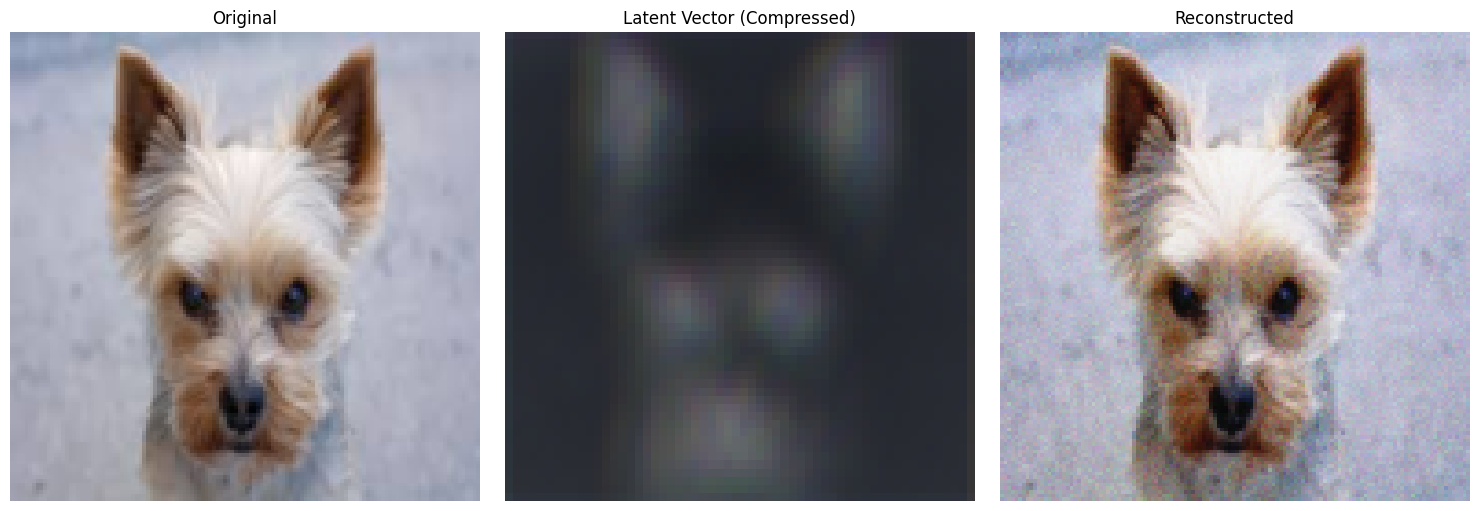

In [95]:
plt.figure(figsize=(15, 5))

# 원본 이미지 (128x128)
plt.subplot(1, 3, 1)
plt.title("Original")
# 원본 이미지를 그대로 출력
plt.imshow(img.squeeze(0).permute(1, 2, 0).cpu())  # 배치 차원 제거 후 시각화
plt.axis("off")

# 잠재벡터 (압축된 잠재벡터 시각화)
plt.subplot(1, 3, 2)
plt.title("Latent Vector (Compressed)")
plt.imshow(latent_batch.cpu().squeeze(0).permute(1, 2, 0).clamp(0, 1))  # 잠재벡터를 그레이스케일로 출력
plt.axis("off")

# 재구성된 이미지
plt.subplot(1, 3, 3)
plt.title("Reconstructed")
plt.imshow(recon_batch.cpu().squeeze(0).permute(1, 2, 0).clamp(0, 1))  # 첫 번째 배치 이미지
plt.axis("off")

plt.tight_layout()
plt.show()

In [139]:
class Autoencoder_CNN_CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # 인코더: 256x256x3 -> 64x64x8
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=15, padding=1),
            nn.MaxPool2d(2, 2),
            nn.Sigmoid()
        )

        # 디코더: 32x32x4 -> 256x256x3
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(3, 3, kernel_size=15, padding=1),
            nn.Sigmoid()
    )

    def forward(self, x):
        x = self.encoder(x)  # 인코더
        out = self.decoder(x)  # 디코더
        return out, x


In [140]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder_CNN_CNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
input_tensor = img_batch.to(device)

# ───────────────────────────────
# 3. 학습 루프
# ───────────────────────────────
epochs = 1000
model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    output_batch, latent_batch = model(input_tensor)
    loss = criterion(output_batch, input_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}  Loss: {loss.item():.6f}")

# ───────────────────────────────
# 4. 평가 및 시각화
# ───────────────────────────────
model.eval()
with torch.no_grad():
    recon_batch, latent_batch = model(input_tensor)

Epoch 10/1000  Loss: 0.031158
Epoch 20/1000  Loss: 0.026938
Epoch 30/1000  Loss: 0.020531
Epoch 40/1000  Loss: 0.012937
Epoch 50/1000  Loss: 0.007991
Epoch 60/1000  Loss: 0.006611


Epoch 70/1000  Loss: 0.006480
Epoch 80/1000  Loss: 0.006131
Epoch 90/1000  Loss: 0.005808
Epoch 100/1000  Loss: 0.005593
Epoch 110/1000  Loss: 0.005391
Epoch 120/1000  Loss: 0.005211
Epoch 130/1000  Loss: 0.005059
Epoch 140/1000  Loss: 0.004926
Epoch 150/1000  Loss: 0.004808
Epoch 160/1000  Loss: 0.004700
Epoch 170/1000  Loss: 0.004599
Epoch 180/1000  Loss: 0.004505
Epoch 190/1000  Loss: 0.004416
Epoch 200/1000  Loss: 0.004346
Epoch 210/1000  Loss: 0.004260
Epoch 220/1000  Loss: 0.004192
Epoch 230/1000  Loss: 0.004136
Epoch 240/1000  Loss: 0.004059
Epoch 250/1000  Loss: 0.004019
Epoch 260/1000  Loss: 0.003944
Epoch 270/1000  Loss: 0.003924
Epoch 280/1000  Loss: 0.003883
Epoch 290/1000  Loss: 0.003773
Epoch 300/1000  Loss: 0.003738
Epoch 310/1000  Loss: 0.003681
Epoch 320/1000  Loss: 0.003634
Epoch 330/1000  Loss: 0.003728
Epoch 340/1000  Loss: 0.003529
Epoch 350/1000  Loss: 0.003493
Epoch 360/1000  Loss: 0.003436
Epoch 370/1000  Loss: 0.003409
Epoch 380/1000  Loss: 0.003391
Epoch 390/1

In [141]:
latent_batch.shape

torch.Size([1, 3, 58, 58])

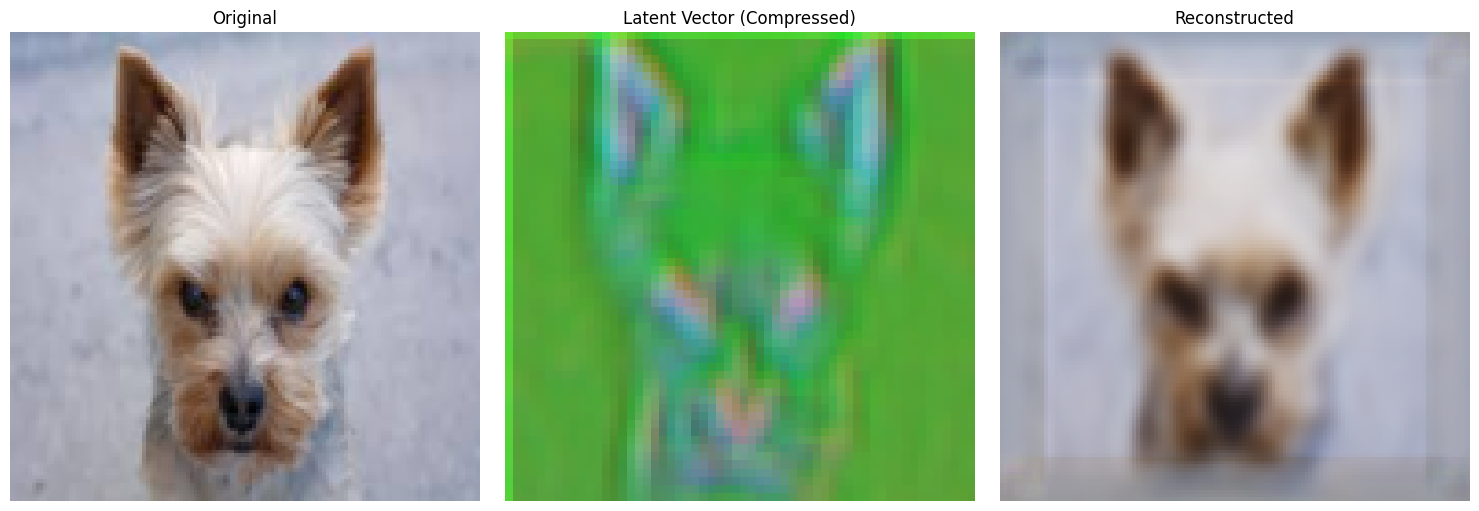

In [142]:
plt.figure(figsize=(15, 5))

# 원본 이미지 (128x128)
plt.subplot(1, 3, 1)
plt.title("Original")
# 원본 이미지를 그대로 출력
plt.imshow(img.squeeze(0).permute(1, 2, 0).cpu())  # 배치 차원 제거 후 시각화
plt.axis("off")

# 잠재벡터 (압축된 잠재벡터 시각화)
plt.subplot(1, 3, 2)
plt.title("Latent Vector (Compressed)")
plt.imshow(latent_batch.cpu().squeeze(0).permute(1, 2, 0).clamp(0, 1))  # 잠재벡터를 그레이스케일로 출력
plt.axis("off")

# 재구성된 이미지
plt.subplot(1, 3, 3)
plt.title("Reconstructed")
plt.imshow(recon_batch.cpu().squeeze(0).permute(1, 2, 0).clamp(0, 1))  # 첫 번째 배치 이미지
plt.axis("off")

plt.tight_layout()
plt.show()

In [97]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_batch = img_batch.to(device)
model = Autoencoder_DNN_DNN().to(device)
#model = Autoencoder_DNN_CNN().to(device)
#model = Autoencoder_CNN_DNN().to(device)
#model = Autoencoder_CNN_CNN().to(device)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100

for epoch in range(epochs):
    model.train()
    output = model(img_batch)
    loss = criterion(output, img_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

# # 5. 학습 결과 확인
model.eval()
with torch.no_grad():
    recon = model(img.to(device))

# 7. 시각화
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(img.squeeze(0).permute(1, 2, 0).cpu())  # 배치 차원 제거 후 시각화
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title(f"{model.__class__.__name__}")
plt.imshow(recon.squeeze(0).permute(1, 2, 0).cpu().clamp(0, 1))  # 배치 차원 제거 후 시각화
plt.axis("off")

plt.show()



AttributeError: 'tuple' object has no attribute 'size'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_batch = img_batch.to(device)



models = [
    Autoencoder_DNN_DNN().to(device),
    Autoencoder_DNN_CNN().to(device),
    Autoencoder_CNN_DNN().to(device),
    Autoencoder_CNN_CNN().to(device)
]

# 학습 파라미터 설정
criterion = nn.MSELoss()
optimizers = [
    optim.Adam(model.parameters(), lr=0.001) for model in models
]
epochs = 30

# 각 모델에 대해 학습
for model, optimizer in zip(models, optimizers):
    model.train()

    for epoch in range(epochs):
        optimizer.zero_grad()  # 각 epoch마다 옵티마이저의 기울기 초기화
        output = model(img_batch)
        loss = criterion(output, img_batch)

        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Model: {model.__class__.__name__}, Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")


# 학습 결과 시각화
model.eval()
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

# 원본 이미지 시각화
axes[0].imshow(img.squeeze(0).permute(1, 2, 0).cpu())
axes[0].set_title("Original")
axes[0].axis("off")

# 각 모델의 재구성된 이미지 시각화
for i, model in enumerate(models):
    with torch.no_grad():
        recon = model(img.to(device))  # 모델에 의해 재구성된 이미지
    axes[i+1].imshow(recon.squeeze(0).permute(1, 2, 0).cpu())  # 결과 이미지 시각화
    axes[i+1].set_title(f"{model.__class__.__name__}")
    axes[i+1].axis("off")

plt.show()